In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
from scipy.integrate import odeint, solve_bvp
from IPython import display

import surrogate as sg
from scipy.spatial.distance import cdist
import cv2

In [2]:
N = 100

xmin = -10
xmax = 10
ymin = -10
ymax = 10

bscale = 1
l = 2

x = np.linspace(xmin,xmax,N)
y = np.linspace(ymin,ymax,N)

xx,yy = np.meshgrid(x,y)

occupancy_grid = np.zeros((N,N))
# occupancy_grid[0,:] = 1
# occupancy_grid[N-1,:] = 1
# occupancy_grid[:,N-1] = 1
# occupancy_grid[:,0] = 1

# n_obstacles = 10
#occupancy_grid[np.random.randint(0,N,n_obstacles),np.random.randint(0,N,n_obstacles)] = 1
# occupancy_grid[50,50] = 1
for j in range(40,60):
    occupancy_grid[j,50] = 1


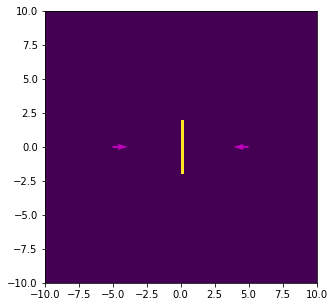

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(occupancy_grid,origin='lower',extent=[xmin,xmax,ymin,ymax])
plt.quiver(-5,0,np.cos(0),np.sin(0),color='m')
plt.quiver(5,0,np.cos(-np.pi),np.sin(np.pi),color='m')
plt.show()

In [4]:
def get_border_cost_grad(x):
    x = x[:,:,np.newaxis]
    mu = (np.vstack((xx.ravel(),yy.ravel())))[np.newaxis,:,occupancy_grid.ravel()==1]

    dx = -bscale/l*np.sum(np.exp(-0.5*np.sum((x-mu)**2,axis=1)/l)*(x[:,0,:]-mu[:,0,:]),axis=1)
    dy = -bscale/l*np.sum(np.exp(-0.5*np.sum((x-mu)**2,axis=1)/l)*(x[:,1,:]-mu[:,1,:]),axis=1)
    
    return np.vstack((dx,dy)).T

In [5]:
def bvp(t,x):
    
    odx = get_border_cost_grad(x[0:2,:].T)
    
    dx = -0.5*x[3]*(1+np.cos(2*x[2])) - 0.5*x[4]*np.sin(2*x[2])
    dy = -0.5*x[3]*np.sin(2*x[2]) - 0.5*x[4]*(1-np.cos(2*x[2]))
    dth = -x[5]
    dl1 = -odx[:,0]
    dl2 = -odx[:,1]
    dl3 = 0.5*(x[4]**2-x[3]**2)*np.sin(x[2]) + 0.5*x[3]*x[4]*np.cos(2*x[2])
    
    dxdt = np.vstack((dx,dy,dth,dl1,dl2,dl3))
    
    return dxdt

In [6]:
def bcr(ya,yb):
    return np.hstack((ya[0:3]-init[0:3],yb[0:3]-fin))

In [7]:
T = 20
max_t = 4
init = np.zeros(6,)
init[0] = -5
init[1] = 0
init[2] = 0

fin = np.array([5,0,-np.pi])

t = np.linspace(0,max_t,T)

seed = np.random.randn(6,T)

res_t = solve_bvp(bvp,bcr,t,seed,max_nodes=1000,verbose=2,tol=1e-5)
while not res_t.success:
    seed = np.random.randn(6,T)
    res_t = solve_bvp(bvp,bcr,t,seed,max_nodes=1000,verbose=2,tol=1e-5)


   Iteration    Max residual    Total nodes    Nodes added  
       1          1.86e+01          20             38       
       2          1.96e+01          58             114      
       3          2.65e+01          172            342      
       4          1.46e+00          514          (1026)     
Number of nodes is exceeded after iteration 4, maximum relative residual 1.46e+00.
   Iteration    Max residual    Total nodes    Nodes added  
       1          8.28e+00          20             38       
       2          9.23e+00          58             114      
       3          1.92e+01          172            342      
       4          2.57e+02          514          (1026)     
Number of nodes is exceeded after iteration 4, maximum relative residual 2.57e+02.
   Iteration    Max residual    Total nodes    Nodes added  
       1          7.42e+01          20             38       
       2          1.05e+02          58             114      
       3          1.41e+02          172  

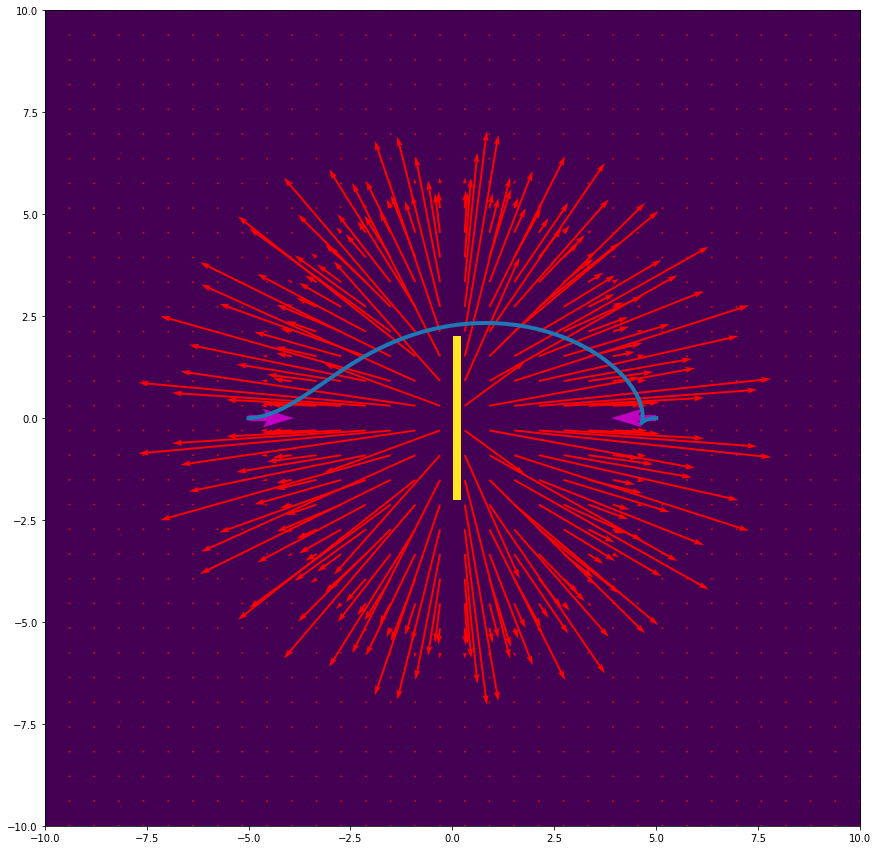

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(occupancy_grid,origin='lower',extent=[xmin,xmax,ymin,ymax])
ddx = get_border_cost_grad(np.vstack((xx.ravel(),yy.ravel())).T)

skip = (slice(None, None, 3), slice(None, None, 3))
plt.quiver(xx[skip],yy[skip],-ddx[:,0].reshape(N,N)[skip],-ddx[:,1].reshape(N,N)[skip],color='r',scale=20)
plt.plot(res_t.y[0,:],res_t.y[1,:],linewidth=4)
plt.quiver(res_t.y[0,0],res_t.y[1,0],np.cos(res_t.y[2,0]),np.sin(res_t.y[2,0]),color='m')
plt.quiver(res_t.y[0,-1],res_t.y[1,-1],np.cos(res_t.y[2,-1]),np.sin(res_t.y[2,-1]),color='m')
plt.show()